# Identifying University clusters in Colombia
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

#### Background

Coverage and access to higher education is a key aspect of a country's development, and is also important for scientific and technological development. It also improves the living conditions of the population. We consider it essential that people have easy access to educational opportunities. This work will allow a first exploration of the regions where the offer of higher education is concentrated in Colombia and those with deficits.

#### Problem

According to the latest statistics published in colombia's national youth and adolescent information system (JUACO), the rate of higher education coverage in Colombia for 2018 was 52.01%; this indicates that about half of the population does not have access to higher education. This analysis allows a preliminary approximation of those regions where the educational offer is scarce and those where it is wide and abundant. With this data, the Ministry of National Education, local administrations or universities could make decisions about where university facilities could be installed.

#### Interest

Entities can use this information to identify places where new university facilities could be installed, or families with the capacity to send their children to study in other cities could determine the regions where the universities are located and according to the costs of living in each region, making the decision on what would be the most viable option.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Location of the university facilities

We decided to group the university facilities based on coordinates to locate clusters.

Following data sources will be needed to extract/generate the required information:
* centers of university facilities will be generated by the query in the cases that the results doesn't have that information. This data will be obtained from **OverPass API**.
* coordinates of universities and their names will be obtained using **OverPass API**, since in Foursquare the data are quite incomplete for Colombia and in the data of the Ministry of National Education on Universities there is no geo-referencing.
* coordinate of Berlin center will be obtained using **Nominatim API geocoding**.

In [1]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
import json
from pandas.io.json import json_normalize
import numpy as np # library to handle data in a vectorized manner
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: | 
  - anaconda/linux-64::ca-certificates-2020.10.14-0, anaconda/linux-64::openssl-1.1.1h-h7b6447c_0
  - anaconda/linux-64::openssl-1.1.1h-h7b6447c_0, defaults/linux-64::ca-certificates-2020.10.14-0
  - anaconda/linux-64::ca-certificates-2020.10.14-0, defaults/linux-64::openssl-1.1.1h-h7b6447c_0
  - defaults/linux-64::ca-certificates-2020.10.14-0, defaults/linux-64::openssl-1.1.1h-h7b6447cdone

# All requested packages already installed.



First we find the coordinates of Colombia to plot the map

In [2]:
address = 'Colombia'

geolocator = Nominatim(user_agent="colombia_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Colombia are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Colombia are 2.8894434, -73.783892.


Due to the lack of data in foursquare and other API's I decided to use OpenStreetMap which has more data about Colombia. So I need to install overpy.

In [3]:
conda install -c conda-forge overpy

Solving environment: / 
  - anaconda/linux-64::ca-certificates-2020.10.14-0, anaconda/linux-64::openssl-1.1.1h-h7b6447c_0
  - anaconda/linux-64::ca-certificates-2020.10.14-0, defaults/linux-64::openssl-1.1.1h-h7b6447c_0
  - anaconda/linux-64::openssl-1.1.1h-h7b6447c_0, defaults/linux-64::ca-certificates-2020.10.14-0
  - defaults/linux-64::ca-certificates-2020.10.14-0, defaults/linux-64::openssl-1.1.1h-h7b6447cdone

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
import overpy
import requests
import json

### Overpass
Overpass API is a service provided by the OpenStreetMap project. It makes it possible to query OpenStreetMap data for objects with specific tags, in a specific area or at a specific point in time. 

It was decided to use OpenStreetMap instead of Foursquare because the information in the former is rather incomplete or outdated for Colombia, while the information in the latter is broader.

The area in which the search will be carried out is first defined, and the following are indications that you want to obtain information related to universities.

We're interested in ojects in 'university' category in Colombia.

In [5]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json][timeout:25];
area(3600120027)->.searchArea;
// gather results
(
  // query part for: “university”
  node["amenity"="university"](area.searchArea);
  way["amenity"="university"](area.searchArea);
  relation["amenity"="university"](area.searchArea);
);
// print results
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

Get and analyse the data from the previous query.

In [6]:
universities = data['elements']
    
colombian_universities = json_normalize(universities) # flatten JSON
colombian_universities.info()

<ipython-input-6-ac060f751207>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  colombian_universities = json_normalize(universities) # flatten JSON


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   type                           612 non-null    object 
 1   id                             612 non-null    int64  
 2   lat                            147 non-null    float64
 3   lon                            147 non-null    float64
 4   tags.amenity                   612 non-null    object 
 5   tags.name                      577 non-null    object 
 6   tags.alt_name                  13 non-null     object 
 7   tags.addr:street               122 non-null    object 
 8   tags.source                    42 non-null     object 
 9   tags.wheelchair                21 non-null     object 
 10  tags.building                  74 non-null     object 
 11  tags.addr:housenumber          67 non-null     object 
 12  tags.name:es                   7 non-null      obj

The information obtained shows that 612 records related to the "University" category were found. It would be interesting to have information about the state or city of the university, however the number of non-null is quite low for most of the fields obtained. But on the other hand the indispensable fields for analysis (coordinates and names) are quite complete. So we take name, latitude and longitude. When the place is defined as a polygon the data of coordinates is returned in center.lat and center.long.

The following table shows that if the lat/lon (147 non-null) and center.lat(465 non-null) fields are joined, the georeferencing data of the 612 records obtained is present.

In [7]:
# filter columns
filtered_columns = ['tags.name', 'lat', 'lon','center.lat','center.lon']
colombian_universities =colombian_universities.loc[:, filtered_columns]

colombian_universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tags.name   577 non-null    object 
 1   lat         147 non-null    float64
 2   lon         147 non-null    float64
 3   center.lat  465 non-null    float64
 4   center.lon  465 non-null    float64
dtypes: float64(4), object(1)
memory usage: 24.0+ KB


We rename the columns.

In [8]:
colombian_universities.columns = ['name', 'lat','lon','center_lat','center_lon']

We need to clean the data. First we replace the missing names with N/A, next we move the coordinates from center.lat and center.lon to lat and long to unify the column of values.

Next, center.lat and center.lon columns are removed because they are no longer needed.

In [9]:
colombian_universities.name.fillna("N/A", inplace=True)
colombian_universities.lat.fillna(colombian_universities.center_lat, inplace=True)
colombian_universities.lon.fillna(colombian_universities.center_lon, inplace=True)
colombian_universities.drop(['center_lat', 'center_lon'], axis=1, inplace=True)

We verify the data once more. 

In [10]:
colombian_universities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    612 non-null    object 
 1   lat     612 non-null    float64
 2   lon     612 non-null    float64
dtypes: float64(2), object(1)
memory usage: 14.5+ KB


In [11]:
print('Colombia has {} university facilities.'.format(colombian_universities.shape[0]))

Colombia has 612 university facilities.


So now we have all the universities in Colombia.

Now we're going to create the map with the information obtained.

In [12]:
# create map of Colombia using latitude and longitude values
map_colombia = folium.Map(location=[latitude, longitude], zoom_start=5, tiles ='Stamen Toner')

# add markers to map
for lat, lng, label in zip(colombian_universities['lat'], colombian_universities['lon'], colombian_universities['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00cc00',
        fill_opacity=0.7,
        parse_html=False).add_to(map_colombia)  
    
map_colombia

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Colombia where there are more universities and those that have low university density.

In first step we have collected the required **data: location and name of every university in Colombia**.

Second step in our analysis will be clustering '**university facilities**' across different areas of Colombia. Since we are using dbscan for clusters, it will help us to identify those areas where the facilities are more concentrated in capital cities and those where the offer covers rural areas.

In third and final step, clusters obtained will be analyzed in order to detect those areas where the supply of universities is wider and those where demand is not covered or centralized in capital cities. 

To create a cluster, we will consider places where there are at least two university installations that are relatively close.

We are going to cluster the university facilities based on coordinates and using DBSCAN. We do it this way because we are more interested in knowing which ones are nearby and it is not certain how many clusters might be needed. We also want to know which of these universities are in remote places.

In [13]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

sklearn.utils.check_random_state(1000)
Clus_dataSet = colombian_universities[['lat','lon']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.25, min_samples=2).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
colombian_universities["Cluster"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
colombian_universities[["name","lat","lon","Cluster"]].head(5)

,name,lat,lon,Cluster
0,centro Universitario,4.920768,-75.072774,0
1,Universidad Pedagógica y Tecnológica de Colombia,5.551848,-73.356604,1
2,San Martín,4.668313,-74.058944,0
3,Universidad de Caldas - Sede Palogrande,5.061315,-75.490434,2
4,Granja Universidad del Tolima,5.006932,-74.907859,0


Now we create the map with the clusters obtained.

In [14]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5,  tiles ='Stamen Toner')

# set color scheme for the clusters
x = np.arange(max(labels)+2)
ys = [i + x + (i*x)**2 for i in range(max(labels)+2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(colombian_universities['lat'], colombian_universities['lon'], colombian_universities['name'], colombian_universities['Cluster']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of universities in every cluster**:

In [15]:
print('There are {} clusters.'.format(len(colombian_universities['Cluster'].unique())-1))

There are 28 clusters.


In [16]:
print('There are {} university facilities relatively isolated.'.format(colombian_universities.loc[colombian_universities['Cluster'] == -1].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == -1]

There are 9 university facilities relatively isolated.


,name,lat,lon,Cluster
50,SENA,9.242145,-74.424747,-1
63,UIS Sede Málaga,6.706655,-72.728330,-1
69,Universidad Popular del Cesar,8.314925,-73.596330,-1
118,Autónoma de Nariño,0.494754,-76.498781,-1
179,Universidad del Tolima,3.717072,-75.475174,-1
394,Unguajira Sede Maicao,11.381180,-72.256029,-1
432,Universidad de antioquia,6.492711,-74.410191,-1
557,Universidad Nacional Abierta y a Distancia - CCAV,2.560176,-72.640384,-1
561,Universidad Nacional Abierta y a Distancia Pit...,1.845995,-76.064840,-1


In [17]:
count_cluster=colombian_universities['Cluster'].value_counts()
summary = count_cluster.to_frame()
summary.columns = ['quantity']
summary.head()

,quantity
0,219
2,104
8,55
4,23
3,22


<AxesSubplot:>

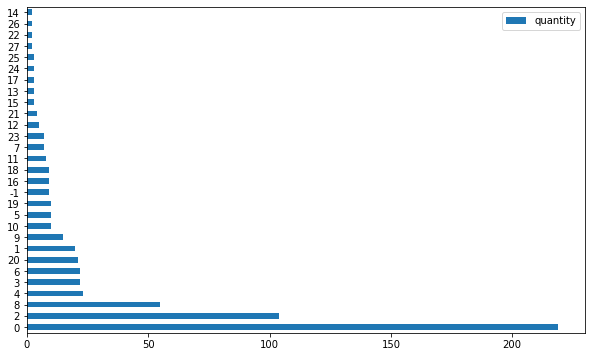

In [18]:
summary.plot(kind='barh', figsize=(10,6))

array([<AxesSubplot:ylabel='quantity'>], dtype=object)

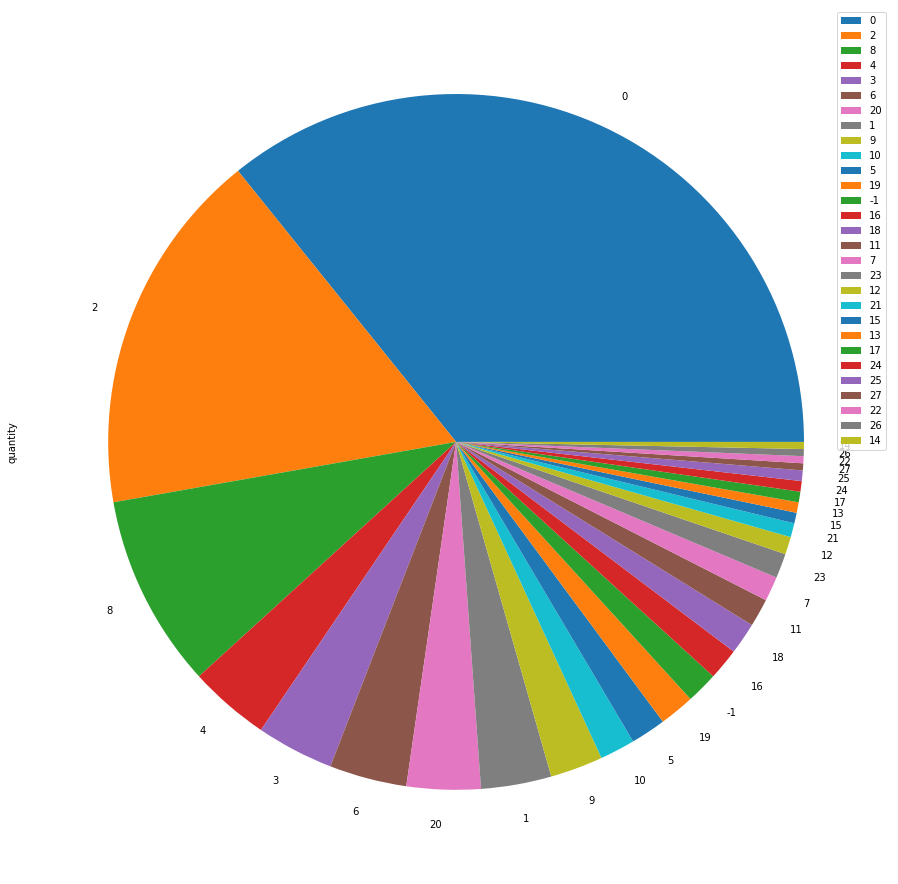

In [19]:
summary.plot(kind='pie', figsize=(18,16), subplots=True)

We can see that more than 50% of the university facilities belong to the clusters 0 an 2.

Let's see some numbers to view in detail how these university facilities are distributed among the clusters.

In [20]:
summary = summary.reset_index()
summary.columns = ['cluster', 'quantity']
total_facilities = summary['quantity'].sum()
summary['percentage'] = summary.quantity / total_facilities
summary

,cluster,quantity,percentage
0,0,219,0.357843
1,2,104,0.169935
2,8,55,0.089869
3,4,23,0.037582
4,3,22,0.035948
5,6,22,0.035948
6,20,21,0.034314
7,1,20,0.032680
8,9,15,0.024510
9,10,10,0.016340


## The clusters 0 and 2 have more than 50% of the university facilities in Colombia. Let's explore this two clusters:

In [21]:
i=0
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 0 has 219 university facilities.


,name,lat,lon,Cluster
0,centro Universitario,4.920768,-75.072774,0
2,San Martín,4.668313,-74.058944,0
4,Granja Universidad del Tolima,5.006932,-74.907859,0
6,Universidad de los Andes -Práctica Médica,4.694160,-74.033548,0
13,passport,4.682505,-74.057331,0
...,...,...,...,...
604,Universidad de Ibagué,4.449643,-75.199246,0
605,Universidad Distrital Francisco José de Caldas...,4.637028,-74.185775,0
606,Universidad Santo Tomás sede principal,4.638153,-74.064439,0
607,Universidad Libre,4.594840,-74.075156,0


In [22]:
i=2
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 2 has 104 university facilities.


,name,lat,lon,Cluster
3,Universidad de Caldas - Sede Palogrande,5.061315,-75.490434,2
7,Universidad Autónoma de Manizales,5.066886,-75.504299,2
8,Universidad de Caldas - Facultad de Ciencias p...,5.063438,-75.499609,2
21,Universidad del Valle - Buga,3.898126,-76.301351,2
30,Antonio Nariño,5.045150,-75.528813,2
...,...,...,...,...
599,Universidad Cooperativa de Colombia,3.390726,-76.550848,2
600,Unicatólica,3.345954,-76.540417,2
601,Universidad Libre,3.361544,-76.526532,2
602,Corporación Universitaria Minuto de Dios,3.438206,-76.543394,2


### Cluster 0 (Bogotá and northern Tolima region )

This cluster with 219 university facilities, consists mainly of universities located in the city of Bogotá, capital of Colombia.

### Cluster 2 (coffee region, Valle del Cauca and Cauca)

This cluster with 104 university facilities and distributed in 5 states, contains two small cities, but with a great tradition of higher education and high participation of students in their daily life: Manizales and Popayán.

In addition there are many university facilities distributed in towns and small cities that are not capital cities of the respective states.

This, added to the relative proximity between cities caused this cluster to cover a relatively wide area, unlike other clusters more concentrated in large cities.

## Other interesting clusters

### Caribbean coast region ( Clusters 6, 9, 13, 18, 20 and 24)

These clusters are characterized by having the educational offer focused mainly on departmental capitals with little or no coverage in villages and rural areas.

It consists of the departments of Cordoba, Sucre, Bolivar, Atlántico, Magdalena and La Guajira.

In [23]:
i=6
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 6 has 22 university facilities.


,name,lat,lon,Cluster
18,SENA - Sede Principal,10.406060,-75.502480,6
19,Universidad del Sinu,10.389532,-75.499706,6
49,Universidad Tecnológica de Bolívar,10.370497,-75.465717,6
126,"UNITECNAR, Fundacion Universitaria Antonio de ...",10.407087,-75.504554,6
169,Universidad de Cartagena,10.425682,-75.549902,6
176,Universidad del Sinú,10.420501,-75.532820,6
181,Universidad de Cartagena,10.427040,-75.551007,6
182,Colegio Mayor de Bolívar,10.425995,-75.552340,6
183,Universidad de Cartagena - Sede Piedra de Bolívar,10.402044,-75.505593,6
184,Universidad Tecnológica de Bolívar,10.412944,-75.538113,6


In [24]:
i=9
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 9 has 15 university facilities.


,name,lat,lon,Cluster
52,UNIVERSIDAD DE SUCRE,9.315062,-75.388294,9
53,Centro de Diagnóstico Médico Universidad de Su...,9.304567,-75.400820,9
54,FUNDETEC,9.305833,-75.397120,9
55,FUNDACION UNIVERSITARIA SAN MARTIN,9.305159,-75.392798,9
56,CEPRODENT,9.303042,-75.395493,9
57,POLITECNICO INDES,9.304300,-75.393589,9
58,SENA Sede La Gallera,9.238065,-75.414139,9
59,UNIVERSIDAD SANTO TOMAS,9.306679,-75.399582,9
316,Universidad de Sucre,9.316756,-75.387207,9
330,SENA SINCELEJO SEDE BOSTON,9.302831,-75.380296,9


In [25]:
i=13
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 13 has 3 university facilities.


,name,lat,lon,Cluster
93,Sede Universitaria San Martin,11.519494,-72.876530,13
257,Escuela Antonio Nariño,11.538035,-72.894407,13
584,N/A,11.512144,-72.870554,13


In [26]:
i=18
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 18 has 9 university facilities.


,name,lat,lon,Cluster
157,Sede Administrativa Universidad del Sinú,8.755807,-75.884488,18
213,Tecnologico San Agustin,8.756927,-75.882070,18
255,Universidad de Córdoba Sede Lorica,9.244677,-75.808538,18
256,SENA LORICA,9.225438,-75.826664,18
280,Inter System Express,9.226918,-75.820278,18
340,Universidad Pontificia Bolivariana,8.804035,-75.850679,18
480,Universidad Cooperativa de Colombia,8.766339,-75.868875,18
481,Universidad de Córdoba,8.790570,-75.861697,18
530,"Universidad del Sinú Campus ""Elias Bechara Zai...",8.767497,-75.886249,18


In [27]:
i=20
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 20 has 21 university facilities.


,name,lat,lon,Cluster
168,Universidad del Norte,11.019139,-74.851245,20
285,Fundación Universitaria San Martín Sede Caribe,11.021214,-74.866367,20
286,Universidad Libre Sede Norte,11.021543,-74.865506,20
288,Universidad Simon Bolivar sede 1,10.994003,-74.792231,20
309,Universidad Libre,10.988935,-74.788089,20
382,ITSA Barranquilla,10.986742,-74.787637,20
383,Universidad del Atlántico Facultad de Bellas A...,10.996901,-74.798513,20
404,Universidad del Atlántico,11.017708,-74.873841,20
408,Politécnico Costa Atlantico,10.986538,-74.819011,20
410,Universidad Metropolitana,10.992954,-74.813216,20


In [28]:
i=24
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 24 has 3 university facilities.


,name,lat,lon,Cluster
326,Universidad del Magdalena,11.224176,-74.185418,24
482,Universidad Cooperativa de Colombia,11.224486,-74.170662,24
529,Universidad Antonio Nariño,11.221588,-74.173002,24


## Clusters with little coverage (Clusters 14, 22, 26 and 27)

Each of these clusters has two university facilities and can be divided into two different types of clusters: 
* departmental capitals of difficult access
* towns with significant economic development

In the first category are San Andrés in the archipelago of San Andrés, Providencia and Santa Catalina and Leticia in the Amazon. In the second category are Magangué and Amalfi.

In [29]:
i=26
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 26 has 2 university facilities.


,name,lat,lon,Cluster
518,Universidad de Antioquia _ Sede Amalfi,6.907116,-75.073926,26
596,Politécnico Jaime Isaza Cadavid,6.913732,-75.081866,26


In [30]:
i=14
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 14 has 2 university facilities.


,name,lat,lon,Cluster
105,Universidad Nacional de Colombia - Sede Caribe,12.536242,-81.707875,14
450,Christian University of San Andres Island,12.492488,-81.734464,14


In [31]:
i=22
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 22 has 2 university facilities.


,name,lat,lon,Cluster
234,N/A,9.252289,-74.758366,22
550,ESAP,9.241027,-74.749710,22


In [32]:
i=27
print('The cluster {} has {} university facilities.'.format(i,colombian_universities.loc[colombian_universities['Cluster'] == i].shape[0]))
colombian_universities.loc[colombian_universities['Cluster'] == i]

The cluster 27 has 2 university facilities.


,name,lat,lon,Cluster
525,Alojamentos universitarios,-4.192063,-69.940078,27
526,Universidad Nacional de Colombia - Sede Amazonas,-4.193926,-69.940575,27


### Archipiélago and Leticia

The archipelago of San Andrés, Providencia and Santa Catalina is a department of difficult access and given its distance from the continental region of Colombia requires special conditions for the provision of services by the Colombian government.

A similar situation occurs with Leticia because of its location within the Amazon rainforest and like the archipelago is a border region of special interest to national sovereignty.

### Magangué and Amalfi

Magangué has about 200,000 inhabitants and is the economic epicenter of a vast area of the southern Bolivar region; it is also the most important river port of cabotage of the Magdalena River, being the one with the largest port movement in Colombia.

Amalfi is the largest municipality in the northeastern region of the department of Antioquia, which stands out for its gold production.

## Results and Discussion <a name="results"></a>

* Difficulties in obtaining complete and reliable information

The main problem in addressing and solving the problem was access to complete, up-to-date and reliable data in Colombia databases. Neither in foursquare nor in other information systems could reliable and complete information be found, and in several cases the data found in one source did not correspond or were not groupable with other sources.

* Concentration of universities in the Andean area and low coverage in the area of orinoquía and the Amazon

As can be seen from the maps and clusters obtained, most universities in Colombia are in the Andean zone and the departments of the Pacific, Amazon and Orinoquía regions have extremely low coverage in higher education.

* Concentration of supply in departmental capitals

In the department of Antioquia and the caribbean coast region, the offer of higher education institutions is concentrated in departmental capitals with very low coverage in the remote areas of the departments.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to locate Universities in Colombia in order to aid the Ministry of National Education, local administrations and universities to identify those areas or regions that may host or may need new university facilities. 

By creating clusters with DBSCAN using the information obtained from OpenStreetMap data we have identified the regions where the universities are concentrated and those where there are isolated university facilities.

Clustering of those locations allowed us to identify areas with interesting behaviors. For example, those where the educational offer is centered in departmental capitals, small cities with important economic activity, regions with wide educational coverage and remote areas with low coverage..

Decisions on the relevance of opening new university facilities in isolated areas or diversification of academic programmes in areas where many universities are concentrated would be taken by the Ministry of National Education, local administrations or universities based on specific characteristics of the regions, taking into consideration additional factors like social and economic dynamics of every region.

In future developments it would be interesting to cross this information with that of the Ministry of National Education on registered and accredited universities to obtain information by departments and municipalities of university facilities.